### 분석 내용 설명 
- 참고한 논문: "Hybrid Forecast of S&P 500 Volatility ensembled from VIX, GARCH and LSTM models" (https://arxiv.org/abs/2407.16780)
- 분석 목표는 아래와 같다 
-   지수의 실현 변동성을 예측해본다 
-   이때 LSTM 모델을 활용한다 
- 비교하는 모델은 총 세가지로 아래와 같다 
    - LSTM 
        - 입력 정보:
            - 가격 정보(SPX 로그수익률)
            - lagged realized volatility (가격 기반 파생 변수)
    - LSTM-GARCH 
        - 입력 정보:
            - 가격 정보(SPX 로그수익률)
            - lagged realized volatility (가격 기반 파생 변수)
            - GARCH(2,2) 예측 변동성 단기 변동성에 대한 추가 정보를 포함 
            - GARCH(2,2) 모델로 선택한 이유는 참고한 논문에서 해당 모형이 SPX 변동성 예측에 가장 정확도가 높았다고 명시했기 때문
    - Hybrid (LSTM-GARCH + VIX):
        - 입력 정보:
            - 가격 정보(SPX 로그수익률)
            - lagged realized volatility (가격 기반 파생 변수)
            - GARCH(2,2) 예측 변동성 
            - VIX 지수 : 앞으로 30일 동안의 기대 변동성 정보를 포함 

- LSTM 모델 구조는 세가지 모두 통일 
- 2층 LSTM으로 각 층당 , 128 유닛, 드롭아웃은 0.1로 설정 
  - 1. LSTM(128 units, `tanh`, `return_sequences=True`) 
    - 하나의 입력은 22개의 시계열 관측치로 구성 (룩백 윈도우=22)
    - 각 입력에 대해 128개의 특징으로 요약하도록 구성
      - 128 개의 특징으로 설정할 경우, 시계열의 복잡한 패턴을 충분히 학습할 수 있다고 알려져 있기 때문 (논문 참고)
    - 총 22 * 128 크기의 출력을 생성 
    - LSTM gate 로 `tanh' activation 함수를 사용했는데 이는 시계열 데이터에서 일반적으로 좋은 성능을 보이기 때문 (논문 참고)
    - 오버피팅을 방지하기 위해서, 0.1의 드롭아웃 적용
  - 2. LSTM(128 units, `tanh`, `return_sequences=False`)
    - 첫 번째 LSTM 층의 출력을 입력으로 받아서, 시계열 특징을 더 추출 
    - 128개의 특징으로 요약된 벡터를 출력 
    - 오버피팅 방지를 위해서, 0.1의 드롭아웃 적용
- 마지막 출력층에서 Relu 활성화 함수를 사용 128개의 특징을 하나의 변동성 값으로 추출 
    - 변동성은 음수가 될 수 없기 떄문에, 출력값을 0이상으로 하기 위해 ReLu를 사용 
- 모델 예측 시,EarlyStopping을 적용하여, Val_loss가 10 epoch(회) 동안 개선되지 않으면 가장 성능이 좋았던 weights으로 복원하도록 설정하였음 

- 각 모델에서 사용하는 feature는 다음과 같다 
    - LSTM: ["ret", "lag_realized_vol"]
    - LSTM-GARCH: ["ret", "lag_realized_vol", "garch_vol"]
    - Hybrid (LSTM-GARCH + VIX): ["ret", "lag_realized_vol", "garch_vol", "vix"]

- Test, Validation 기간: 2020-01-01 ~ 2024-12-31
- Train 70%, Val 15%, Test 15% 로 대략 2년치의 데이터를 예측하도록 함 
- 평가 지표: RMSE, MAE이며, 예측한 변동성과, 실제 변동성(realized_vol) 간의 오차를 시각화 

- 결과: 세 모델 비교 결과, LSTM이 가장 낮은 MAE(0.000546)와 RMSE(0.000791)로 가장 우수했고, LSTM-GARCH가 그다음, Hybrid(LSTM-GARCH + VIX)가 가장 성능이 낮게 나타났다.

In [19]:
 # 라이브러리와 기본 설정 값 가져오기

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from arch import arch_model

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
tf.keras.utils.set_random_seed(4035)
tf.config.experimental.enable_op_determinism()

import yfinance as yf

np.random.seed(4035)
tf.random.set_seed(4035)


In [20]:
#   파생 변수 생성

spx_ticker="^GSPC"
vix_ticker="^VIX"
start="2000-01-01"
end="2024-12-31"

spx = yf.download(spx_ticker, start=start, end=end)
vix = yf.download(vix_ticker, start=start, end=end)

# print(spx.head())

# print(vix.head())

# 1) 'Close' 레벨에서 첫 번째 컬럼(=그 티커)만 Series로 뽑기
spx_close = spx["Close"].iloc[:, 0]   # (N, ) Series
vix_close = vix["Close"].iloc[:, 0]   # (N, ) Series

# 2) 이름 붙이기
spx_close = spx_close.rename("SPX")
vix_close = vix_close.rename("VIX")

# 3) 옆으로 붙이기
df = pd.concat([spx_close, vix_close], axis=1).dropna()
print(df.head())
print(df.shape)


C:\Users\jys97\AppData\Local\Temp\ipykernel_25996\3043771992.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spx = yf.download(spx_ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
C:\Users\jys97\AppData\Local\Temp\ipykernel_25996\3043771992.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download(vix_ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

                    SPX        VIX
Date                              
2000-01-03  1455.219971  24.209999
2000-01-04  1399.420044  27.010000
2000-01-05  1402.109985  26.410000
2000-01-06  1403.449951  25.730000
2000-01-07  1441.469971  21.719999
(6288, 2)


In [21]:
vol_window = 22 
df['ret'] = np.log(df['SPX']/df['SPX'].shift(1))
df['realized_vol'] = df['ret'].rolling(window=vol_window).std()
df['lag_realized_vol'] = df['realized_vol'].shift(1)
df = df.dropna()
print(df.head())
print(df.isna().sum())
print(df['realized_vol'].describe())

                    SPX        VIX       ret  realized_vol  lag_realized_vol
Date                                                                        
2000-02-04  1424.369995  21.540001 -0.000421      0.013582          0.016031
2000-02-07  1424.239990  22.790001 -0.000091      0.013581          0.013582
2000-02-08  1441.719971  21.250000  0.012198      0.013801          0.013581
2000-02-09  1411.709961  22.900000 -0.021035      0.013346          0.013801
2000-02-10  1416.829956  23.070000  0.003620      0.013117          0.013346
SPX                 0
VIX                 0
ret                 0
realized_vol        0
lag_realized_vol    0
dtype: int64
count    6265.000000
mean        0.010335
std         0.006669
min         0.002164
25%         0.006196
50%         0.008620
75%         0.012603
max         0.060027
Name: realized_vol, dtype: float64


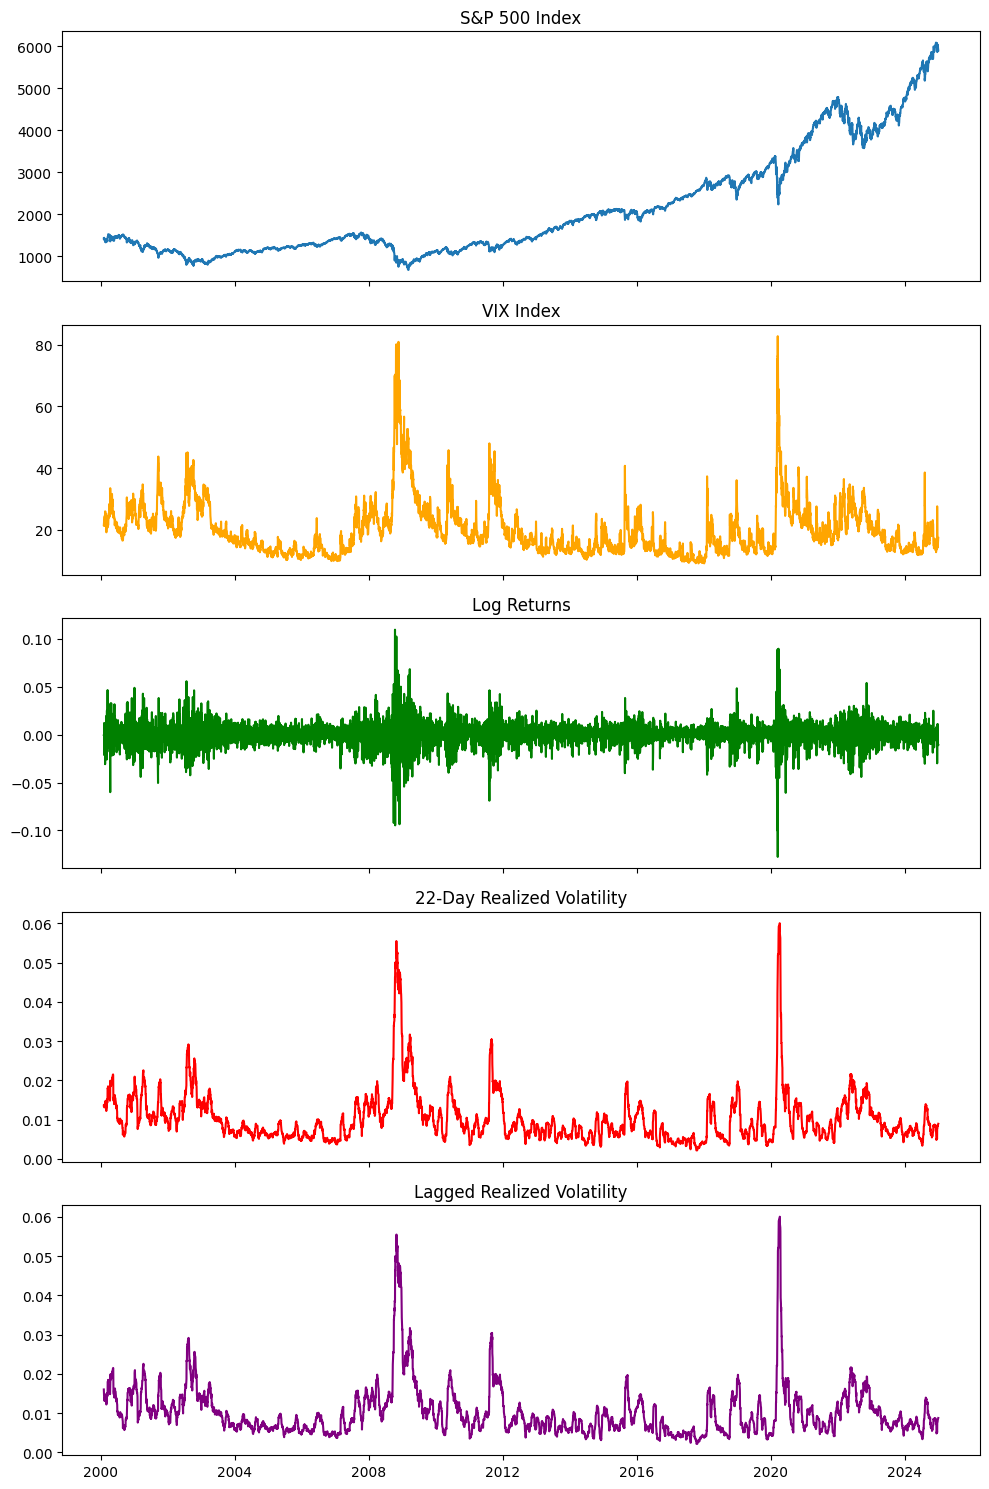

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
axs[0].plot(df.index, df['SPX'])
axs[0].set_title('S&P 500 Index')
axs[1].plot(df.index, df['VIX'], color='orange')
axs[1].set_title('VIX Index')
axs[2].plot(df.index, df['ret'], color='green')
axs[2].set_title('Log Returns')
axs[3].plot(df.index, df['realized_vol'], color='red')
axs[3].set_title('22-Day Realized Volatility')
axs[4].plot(df.index, df['lag_realized_vol'], color='purple')
axs[4].set_title('Lagged Realized Volatility')
plt.tight_layout()
plt.show()

In [23]:
returns = df["ret"].dropna()
dates = returns.index
garch_forecasts = pd.Series(index=dates, dtype=float)

p, q = 2, 2 # GARCH(2,2) 모델 적용 
initial_window = 1500  

if len(returns) <= initial_window + 1:
    raise ValueError(f"initial_window={initial_window} 이(가) 너무 큼. "
                     f"returns 길이={len(returns)} 확인해서 줄여줘.")

print("GARCH is rolling..")
for i in range(initial_window, len(returns) - 1):
    train_data = returns.iloc[:i]

    am = arch_model(
        train_data * 100, 
        mean="Zero",
        vol="GARCH",
        p=p,
        q=q,
        dist="normal",
    )
    res = am.fit(disp="off")

    forecast = res.forecast(horizon=1)
    sigma2_t1 = forecast.variance.values[-1, 0]

    garch_forecasts.iloc[i + 1] = np.sqrt(sigma2_t1)

print("GARCH forcast count:", garch_forecasts.notna().sum())

garch_forecasts.name = "garch_vol_pred"

# df에 merge 해서, LSTM feature로 사용 준비 
df = df.join(garch_forecasts, how="left")
df = df.dropna()
print("GARCH 예측 merge 후 데이터 크기:", df.shape)
print(df[["ret", "realized_vol", "lag_realized_vol", "garch_vol_pred", "VIX"]].head())

GARCH is rolling..
GARCH forcast count: 4764
GARCH 예측 merge 후 데이터 크기: (4764, 6)
                 ret  realized_vol  lag_realized_vol  garch_vol_pred    VIX
Date                                                                       
2006-01-26  0.007209      0.006985          0.006870        0.740898  12.42
2006-01-27  0.007734      0.007168          0.006985        0.739181  11.97
2006-01-30  0.001144      0.006801          0.007168        0.715838  12.39
2006-01-31 -0.003984      0.006883          0.006801        0.733648  12.95
2006-02-01  0.001858      0.006834          0.006883        0.723744  12.36


### Model 1: Predict Realized Volatility using Only LSTM 

In [24]:
# LSTM용 데이터셋 만들기
#  - feature: ret, lag_realized_vol 
#  - target: realized_vol
#  - 시퀀스: lookback 길이

feature_cols = ["ret", "lag_realized_vol"]  
target_col = "realized_vol"
lookback = 22

data = df.copy()

X_raw = data[feature_cols].values
y_raw = data[target_col].values.reshape(-1, 1)

In [25]:
# train / val / test 분할

n = len(X_raw)
n_train = int(n * 0.7)
n_val = int(n * 0.15)

X_raw_train = X_raw[:n_train]
X_raw_val   = X_raw[n_train:n_train + n_val]
X_raw_test  = X_raw[n_train + n_val:]

y_raw_train = y_raw[:n_train]
y_raw_val   = y_raw[n_train:n_train + n_val]
y_raw_test  = y_raw[n_train + n_val:]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_raw_train)
y_train_scaled = scaler_y.fit_transform(y_raw_train)

X_val_scaled   = scaler_X.transform(X_raw_val)
y_val_scaled   = scaler_y.transform(y_raw_val)

X_test_scaled  = scaler_X.transform(X_raw_test)
y_test_scaled  = scaler_y.transform(y_raw_test)

# Train
X_train_list = []
y_train_list = []
for i in range(lookback, len(X_train_scaled)):
    X_train_list.append(X_train_scaled[i - lookback:i])
    y_train_list.append(y_train_scaled[i, 0])
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

# Val
X_val_list = []
y_val_list = []
for i in range(lookback, len(X_val_scaled)):
    X_val_list.append(X_val_scaled[i - lookback:i])
    y_val_list.append(y_val_scaled[i, 0])
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)

# Test
X_test_list = []
y_test_list = []
for i in range(lookback, len(X_test_scaled)):
    X_test_list.append(X_test_scaled[i - lookback:i])
    y_test_list.append(y_test_scaled[i, 0])
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)


print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (3312, 22, 2) (3312,)
Val  : (692, 22, 2) (692,)
Test : (694, 22, 2) (694,)


In [26]:
# LSTM 모델 정의 & 학습

input_shape = X_train.shape[1:]  # (lookback, n_features)
print("LSTM 입력 형태:", input_shape)

param_options=[
    {"units": 64 , "dropout": 0.1, "lr": 0.001},
    {"units": 128, "dropout": 0.1, "lr": 0.001},
    {"units": 128, "dropout": 0.2, "lr": 0.001},
    {"units": 128, "dropout": 0.1, "lr": 0.0005},
]

# lstm_units = 128
# num_layers = 2
# dropout_rate = 0.1

best_val_loss_1 = np.inf
best_cfg_1 = None
best_model_1 = None

for i, cfg in enumerate(param_options, start=1):
    print(f"\n=== Trial {i}: {cfg} ===")
    lstm_units = cfg["units"]
    dropout_rate = cfg["dropout"]
    learning_rate = cfg["lr"]
    num_layers = 2

    model = models.Sequential()
    # 첫 번째 LSTM
    model.add(
        layers.LSTM(
            cfg["units"],
            activation="tanh",
            return_sequences=(num_layers > 1),
            input_shape=input_shape,
        )
    )
    model.add(layers.Dropout(cfg["dropout"]))

    # 두 번째 LSTM (num_layers=2 기준)
    model.add(
        layers.LSTM(
            cfg["units"],
            activation="tanh",
            return_sequences=False,
        )
    )
    model.add(layers.Dropout(cfg["dropout"]))

    # 출력층
    model.add(layers.Dense(1, activation="relu"))
    # Relu를 사용함으로써 0 이상으로 나오도록 강제 및 선형적으로 숫자가 커짐으로써 큰 변동성 spike도 잡아내도록 

    model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=cfg["lr"]),
    )

    print(model.summary())

    es = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=64,
        shuffle=False,
        callbacks=[es],
        verbose=1,
    )
    val_loss = min(history.history["val_loss"])
    print(f"optimal loss: {val_loss:.6f}")

    if val_loss < best_val_loss_1:
        best_val_loss_1 = val_loss
        best_cfg_1 = cfg
        best_model_1 = model
    
print(f"\n=== best model: {best_cfg_1}, val loss: {best_val_loss_1:.6f} ===")

LSTM 입력 형태: (22, 2)

=== Trial 1: {'units': 64, 'dropout': 0.1, 'lr': 0.001} ===


c:\Users\jys97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 22, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0139 - val_loss: 0.0132
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0057 - val_loss: 0.0080
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 - val_loss: 0.0042
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 22, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,785 (776.50 KB)

 Trainable params: 198,785 (776.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0386 - val_loss: 0.0620
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0388 - val_loss: 0.0620
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0388 - val_loss: 0.0620
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0388 - val_loss: 0.0620
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0388 - val_loss: 0.0620
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0388 - val_loss: 0.0620
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0388 - val_loss: 0.0620
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0388 - val_loss: 0.0620
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0388 - val_loss: 0.0620
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0388 - val_loss: 0.0620
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0388 - val_loss: 0.0620
optimal loss: 0.062041

=== Trial 3: {'units': 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 22, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,785 (776.50 KB)

 Trainable params: 198,785 (776.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0112 - val_loss: 0.0122
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.2355e-04 - val_loss: 0.0016
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.2500e-04 - val_loss: 0.0015
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 22, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,785 (776.50 KB)

 Trainable params: 198,785 (776.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0062 - val_loss: 0.0088
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0030 - val_loss: 0.0078
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022 - val_loss: 0.0065
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms

In [27]:
results = {}
y_pred_scaled = best_model_1.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
results["LSTM"] = (mae, rmse)

print("========== Final Results ==========")
print(f"Test MAE : {mae:.6f}")
print(f"Test RMSE: {rmse:.6f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
========== Final Results ==========
Test MAE : 0.000546
Test RMSE: 0.000791


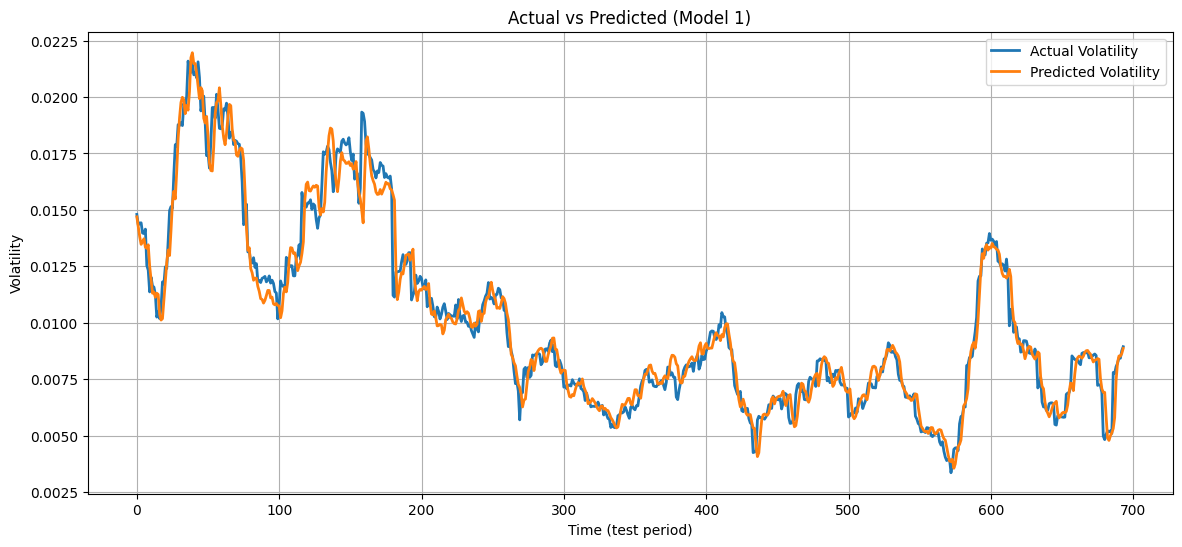

In [28]:
plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Volatility", linewidth=2)
plt.plot(y_pred, label="Predicted Volatility", linewidth=2)
plt.title("Actual vs Predicted (Model 1)")
plt.xlabel("Time (test period)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

### Model 2 : Predict Realized Volatility using LSTM + GARCH 

In [29]:
# LSTM용 데이터셋 만들기
#  - feature: ret, lag_realized_vol, garch_vol_pred
#  - target: realized_vol
#  - 시퀀스: lookback 길이

feature_cols = ["ret", "lag_realized_vol", "garch_vol_pred"]  # 필요에 따라 빼고/추가
target_col = "realized_vol"
lookback = 22

data = df.copy()

X_raw = data[feature_cols].values
y_raw = data[target_col].values.reshape(-1, 1)

n = len(X_raw)
n_train = int(n * 0.7)
n_val = int(n * 0.15)

X_raw_train = X_raw[:n_train]
X_raw_val   = X_raw[n_train:n_train + n_val]
X_raw_test  = X_raw[n_train + n_val:]

y_raw_train = y_raw[:n_train]
y_raw_val   = y_raw[n_train:n_train + n_val]
y_raw_test  = y_raw[n_train + n_val:]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_raw_train)
y_train_scaled = scaler_y.fit_transform(y_raw_train)

X_val_scaled   = scaler_X.transform(X_raw_val)
y_val_scaled   = scaler_y.transform(y_raw_val)

X_test_scaled  = scaler_X.transform(X_raw_test)
y_test_scaled  = scaler_y.transform(y_raw_test)

# Train
X_train_list = []
y_train_list = []
for i in range(lookback, len(X_train_scaled)):
    X_train_list.append(X_train_scaled[i - lookback:i])
    y_train_list.append(y_train_scaled[i, 0])
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

# Val
X_val_list = []
y_val_list = []
for i in range(lookback, len(X_val_scaled)):
    X_val_list.append(X_val_scaled[i - lookback:i])
    y_val_list.append(y_val_scaled[i, 0])
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)

# Test
X_test_list = []
y_test_list = []
for i in range(lookback, len(X_test_scaled)):
    X_test_list.append(X_test_scaled[i - lookback:i])
    y_test_list.append(y_test_scaled[i, 0])
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)


print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (3312, 22, 3) (3312,)
Val  : (692, 22, 3) (692,)
Test : (694, 22, 3) (694,)


In [30]:
# LSTM 모델 정의 & 학습

input_shape = X_train.shape[1:]  # (lookback, n_features)
print("LSTM input shape:", input_shape)

lstm_units   = best_cfg_1["units"]
dropout_rate = best_cfg_1["dropout"]
learning_rate = best_cfg_1["lr"]
num_layers = 2

model = models.Sequential()
# 첫 번째 LSTM
model.add(
    layers.LSTM(
        lstm_units,
        activation="tanh",
        return_sequences=(num_layers > 1),
        input_shape=input_shape,
    )
)
model.add(layers.Dropout(dropout_rate))

# 두 번째 LSTM (layer=2)
model.add(
    layers.LSTM(
        lstm_units,
        activation="tanh",
        return_sequences=False,
    )
)
model.add(layers.Dropout(dropout_rate))

# 출력층
model.add(layers.Dense(1, activation="relu"))

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

print(model.summary())

es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    shuffle=False,
    callbacks=[es],
    verbose=1,
)


LSTM input shape: (22, 3)


c:\Users\jys97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 22, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0084 - val_loss: 0.0089
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.6199e-04 - val_loss: 0.0015
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.0518e-04 - val_loss: 0.0015
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.3448e-04 - val_loss: 0.0015
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━

In [31]:
y_pred_scaled = model.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
results["LSTM-GARCH"] = (mae, rmse)


print("========== Final Results ==========")
print(f"Test MAE : {mae:.6f}")
print(f"Test RMSE: {rmse:.6f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
========== Final Results ==========
Test MAE : 0.000605
Test RMSE: 0.000839


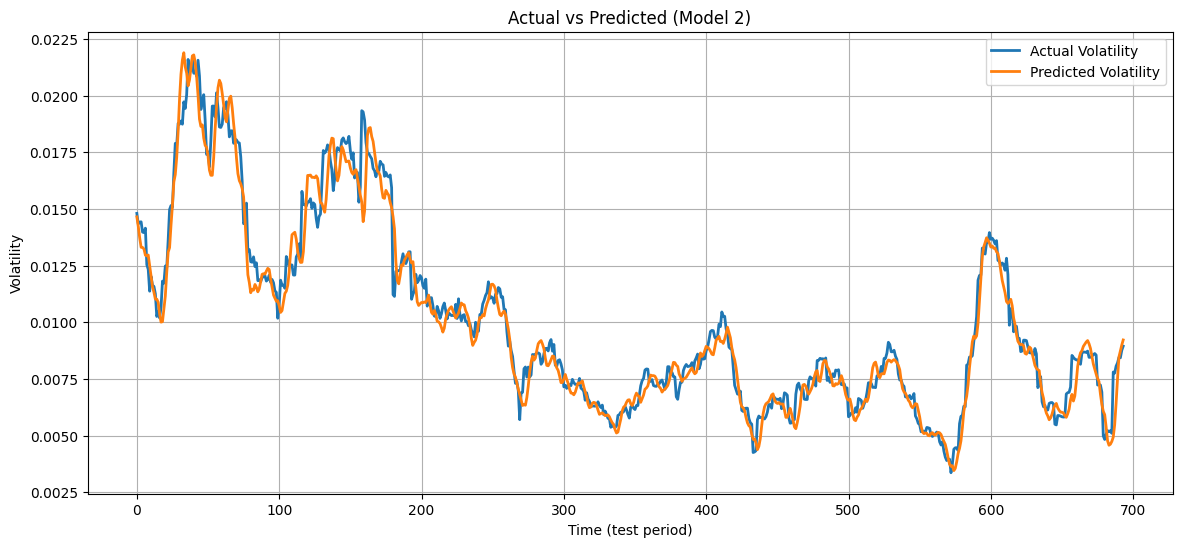

In [32]:
plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Volatility", linewidth=2)
plt.plot(y_pred, label="Predicted Volatility", linewidth=2)
plt.title("Actual vs Predicted (Model 2)")
plt.xlabel("Time (test period)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

### Model 3 : Predict Realized Volatility using LSTM + GARCH + VIX

In [33]:
# LSTM용 데이터셋 만들기
#  - feature: ret, lag_realized_vol, garch_vol_pred, VIX
#  - target: realized_vol
#  - 시퀀스: lookback 길이

feature_cols = ["ret", "lag_realized_vol", "garch_vol_pred", "VIX"]  # 필요에 따라 빼고/추가
target_col = "realized_vol"
lookback = 22

data = df.copy()

X_raw = data[feature_cols].values
y_raw = data[target_col].values.reshape(-1, 1)

n = len(X_raw)
n_train = int(n * 0.7)
n_val = int(n * 0.15)

X_raw_train = X_raw[:n_train]
X_raw_val   = X_raw[n_train:n_train + n_val]
X_raw_test  = X_raw[n_train + n_val:]

y_raw_train = y_raw[:n_train]
y_raw_val   = y_raw[n_train:n_train + n_val]
y_raw_test  = y_raw[n_train + n_val:]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_raw_train)
y_train_scaled = scaler_y.fit_transform(y_raw_train)

X_val_scaled   = scaler_X.transform(X_raw_val)
y_val_scaled   = scaler_y.transform(y_raw_val)

X_test_scaled  = scaler_X.transform(X_raw_test)
y_test_scaled  = scaler_y.transform(y_raw_test)

# Train
X_train_list = []
y_train_list = []
for i in range(lookback, len(X_train_scaled)):
    X_train_list.append(X_train_scaled[i - lookback:i])
    y_train_list.append(y_train_scaled[i, 0])
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

# Val
X_val_list = []
y_val_list = []
for i in range(lookback, len(X_val_scaled)):
    X_val_list.append(X_val_scaled[i - lookback:i])
    y_val_list.append(y_val_scaled[i, 0])
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)

# Test
X_test_list = []
y_test_list = []
for i in range(lookback, len(X_test_scaled)):
    X_test_list.append(X_test_scaled[i - lookback:i])
    y_test_list.append(y_test_scaled[i, 0])
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)


print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (3312, 22, 4) (3312,)
Val  : (692, 22, 4) (692,)
Test : (694, 22, 4) (694,)


In [34]:
# 모델 정의 & 학습

input_shape = X_train.shape[1:]  # (lookback, n_features)
print("LSTM 입력 형태:", input_shape)

lstm_units   = best_cfg_1["units"]
dropout_rate = best_cfg_1["dropout"]
learning_rate = best_cfg_1["lr"]
num_layers = 2

model = models.Sequential()
# 첫 번째 LSTM
model.add(
    layers.LSTM(
        lstm_units,
        activation="tanh",
        return_sequences=(num_layers > 1),
        input_shape=input_shape,
    )
)
model.add(layers.Dropout(dropout_rate))

# 두 번째 LSTM (num_layers=2 기준)
model.add(
    layers.LSTM(
        lstm_units,
        activation="tanh",
        return_sequences=False,
    )
)
model.add(layers.Dropout(dropout_rate))

# 출력층
model.add(layers.Dense(1, activation="relu"))

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

print(model.summary())

es = callbacks.EarlyStopping( 
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    shuffle=False,
    callbacks=[es],
    verbose=1,
)

LSTM 입력 형태: (22, 4)


c:\Users\jys97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 22, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,753 (198.25 KB)

 Trainable params: 50,753 (198.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.4875e-04 - val_loss: 0.0018
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.2408e-04 - val_loss: 0.0018
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.9690e-04 - val_loss: 0.0018
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.5600e-04 - val_loss: 0.0018
Epoch 12/100
52/52 ━━━━━━━━━━━━

In [35]:
y_pred_scaled = model.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
results["Hybrid+VIX"] = (mae, rmse)

print("========== Final Results ==========")
print(f"Test MAE : {mae:.6f}")
print(f"Test RMSE: {rmse:.6f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
========== Final Results ==========
Test MAE : 0.000699
Test RMSE: 0.000949


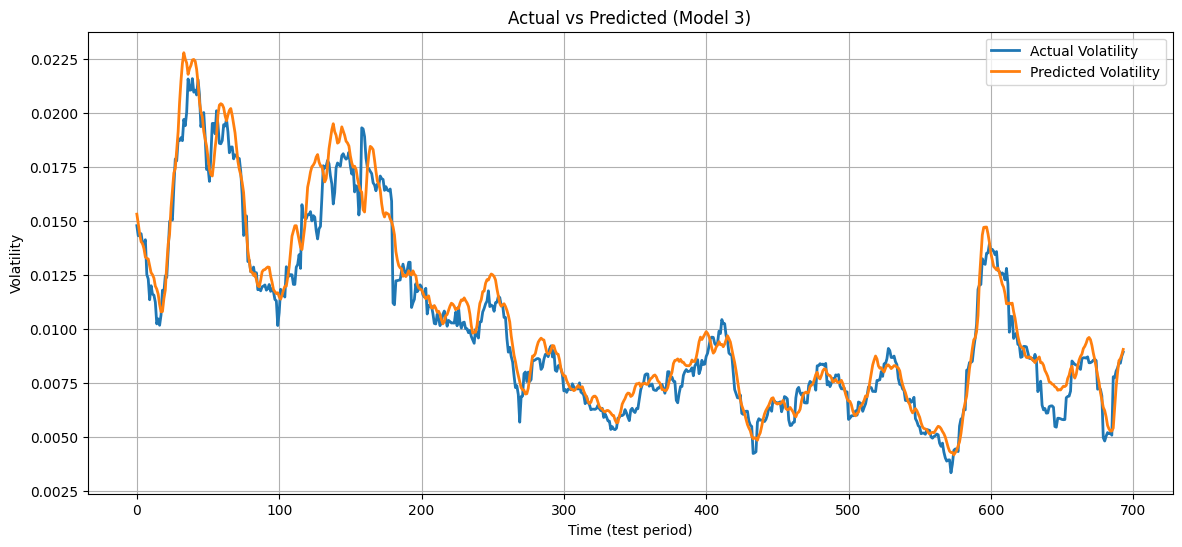

In [36]:
plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Volatility", linewidth=2)
plt.plot(y_pred, label="Predicted Volatility", linewidth=2)
plt.title("Actual vs Predicted (Model 3)")
plt.xlabel("Time (test period)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
result_table = pd.DataFrame(results, index=["MAE", "RMSE"]).T
print(result_table)

                 MAE      RMSE
LSTM        0.000546  0.000791
LSTM-GARCH  0.000605  0.000839
Hybrid+VIX  0.000699  0.000949
